# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

import time

In [ ]:
import warnings
warnings.filterwarnings('ignore')
nltk.download('omw-1.4', quiet=True)

In [ ]:
def extract_main_website(url):
  """
  Extracts the main website from a given URL.

  Args:
      url: The URL to extract the main website from.

  Returns:
      The main website, or None if the URL is invalid.
  """

  # Check for valid URL format
  if not re.match(r'^https?:\/\/.*\..+\/', url):
    return None

  # Remove protocol and www.
  url = url.replace('https://', '').replace('http://', '').replace('www.', '')

  # Find the first occurrence of .com/ or .net/ or .org/
  for suffix in ['.com/', '.net/', '.org/']:
    index = url.find(suffix)
    if index != -1:
      return url[:index + len(suffix)]

  # If none of the above suffixes are found, return the entire domain
  return url.split('/')[0]


# Load datasets

In [ ]:
def read_csv_with_retries(file_path, max_retries=25, delay=1):
    colnames=['sentiment','tw_id', 'date', 'no_query', 'user', 'text']
    for attempt in range(max_retries):
        try:
            df = pd.read_csv(file_path, encoding = 'latin1', names=colnames, header=None)
            return df
        except Exception as e:
            print(f"Attempt {attempt + 1} with failed: {e}")
            time.sleep(delay)
    raise Exception("Failed to read CSV file after multiple attempts")

file_path = 'training.1600000.processed.noemoticon.csv'
df = read_csv_with_retries(file_path)
df.head()

,sentiment,tw_id,date,no_query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
data = pd.read_csv('df_tweets.csv')
print(f'Shape: {data.shape}')
data.head()

Shape: (1436285, 2)


,tw_id,text
0,1988980167,yes please
1,1880404304,much saying cant hypnotised keith barry anything
2,1680771682,great thai chicken pizza loved seeing old co ...
3,1979507798,bet london shows fab roll newcastle amp glasg...
4,1974662314,hey music twitters im studio happy cause compl...


In [ ]:
df_relationships = pd.read_csv('df_relationships.csv')
print(f'Shape: {df_relationships.shape}')
df_relationships.head()

Shape: (738493, 4)


,tw_id,sentiment,user,users_tagged
0,1467810369,0,_TheSpecialOne_,['@switchfoot']
1,1467810917,0,mattycus,['@Kenichan']
2,1467811193,0,Karoli,['@nationwideclass']
3,1467811372,0,joy_wolf,['@Kwesidei']
4,1467811594,0,coZZ,['@LOLTrish']


In [ ]:
new_df = df_relationships[['tw_id', 'users_tagged']].copy()

In [ ]:
data = data.merge(new_df, on='tw_id', how='left')
data.head()

,tw_id,text,users_tagged
0,1988980167,yes please,['@dafwarg']
1,1880404304,much saying cant hypnotised keith barry anything,['@dermotwhelan']
2,1680771682,great thai chicken pizza loved seeing old co ...,['@calpizzakitchen']
3,1979507798,bet london shows fab roll newcastle amp glasg...,['@stephenofficial']
4,1974662314,hey music twitters im studio happy cause compl...,NaN


In [ ]:
def check_all_str(df,column:str):
    all_str = df[column].apply(lambda x: isinstance(x, str)).all()
    print(f"All values in the '{column}' column are strings: {all_str}")
    if not all_str:
      old = df.shape[0]
      df = df.dropna(subset=['text'])
      df.reset_index(drop=True, inplace=True)
      print(f"Dropped {old - df.shape[0]} rows with missing 'text' values.")
      print(f"Remaining rows: {df.shape[0]}")
      return df
    return df


data = check_all_str(data,'text')

# EDA

## Tweets frequency

In [ ]:
user_counts = df['user'].value_counts()
print('min:',user_counts.min())
print('max:',user_counts.max())
print('mean:',user_counts.mean())

top_10_users = user_counts.head(10)
print(top_10_users)


min: 1
max: 549
mean: 2.425069152362548
user
lost_dog           549
webwoke            345
tweetpet           310
SallytheShizzle    281
VioletsCRUK        279
mcraddictal        276
tsarnick           248
what_bugs_u        246
Karen230683        238
DarkPiano          236
Name: count, dtype: int64


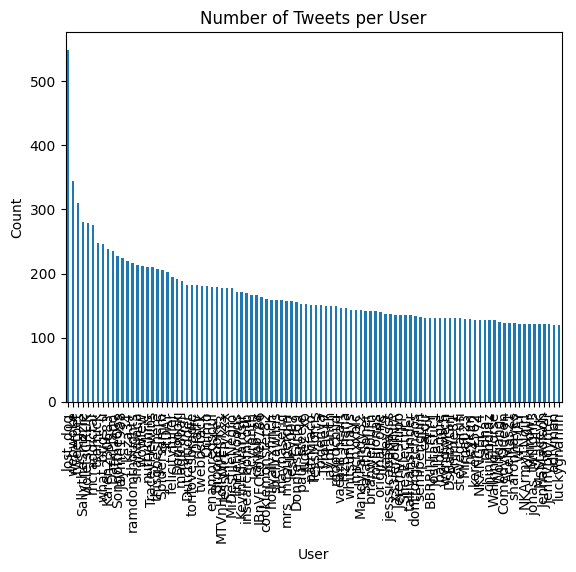

In [ ]:
user_counts.head(100).plot(kind='bar')
plt.xlabel('User')
plt.ylabel('Count')
plt.title('Number of Tweets per User')
plt.show()

## Users tagged

In [ ]:
df_relationships.head()

,tw_id,sentiment,user,users_tagged
0,1467810369,0,_TheSpecialOne_,['@switchfoot']
1,1467810917,0,mattycus,['@Kenichan']
2,1467811193,0,Karoli,['@nationwideclass']
3,1467811372,0,joy_wolf,['@Kwesidei']
4,1467811594,0,coZZ,['@LOLTrish']


In [ ]:
def remove_emails(text):
  """
  This function removes all @gmail, @hotmail and @yahoo from a given text.
  """
  pattern = r'@\b(gmail|hotmail|yahoo)\b'
  text = re.sub(pattern, '', text)
  return text

df_relationships['users_tagged'] = df_relationships['users_tagged'].apply(lambda x: remove_emails(x))


Lista de los 20 usuario mas nombrados

In [ ]:
users_tagged = df_relationships['users_tagged']
names = []
for user in users_tagged:
  names.extend(re.findall(r'@\w+', user))

# Remove duplicates and count occurrences
name_counts = Counter(names)

# Get the 20 most common names and their frequencies
most_common_names = name_counts.most_common(20)

# Print the results
for name, count in most_common_names:
  print(f"{name}: {count}")


@mileycyrus: 4500
@tommcfly: 3887
@ddlovato: 3467
@DavidArchie: 1299
@Jonasbrothers: 1287
@jordanknight: 1130
@DonnieWahlberg: 1104
@mitchelmusso: 1077
@JonathanRKnight: 1074
@taylorswift13: 1011
@jonasbrothers: 986
@selenagomez: 801
@dougiemcfly: 794
@peterfacinelli: 637
@aplusk: 624
@joeymcintyre: 578
@Dannymcfly: 546
@gfalcone601: 540
@shaundiviney: 511
@YoungQ: 507


## Sentiment

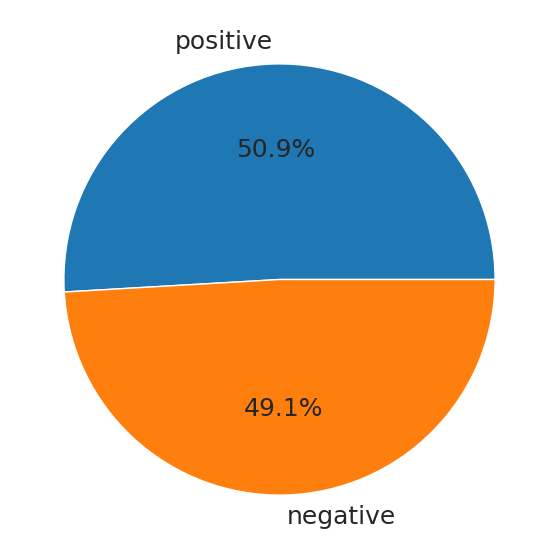

In [ ]:
def sentiments(s):
    if s == 0:
        return 'negative'
    elif s == 4:
        return 'positive'
    else:
        return 'neutral'

data['sentiments'] = data['sentiment'].apply(sentiments)
plt.pie(data['sentiments'].value_counts(), labels=data['sentiments'].unique().tolist(), autopct='%1.1f%%')
plt.show()

In [ ]:
sentiment_by_user = data.groupby('user')['sentiment'].mean()
df_sentiment_table = sentiment_by_user.to_frame().reset_index()
df_sentiment_table = df_sentiment_table.merge(user_counts.to_frame().reset_index(), on='user', how='left')
df_sentiment_table.rename(columns={0: 'users_count'}, inplace=True)

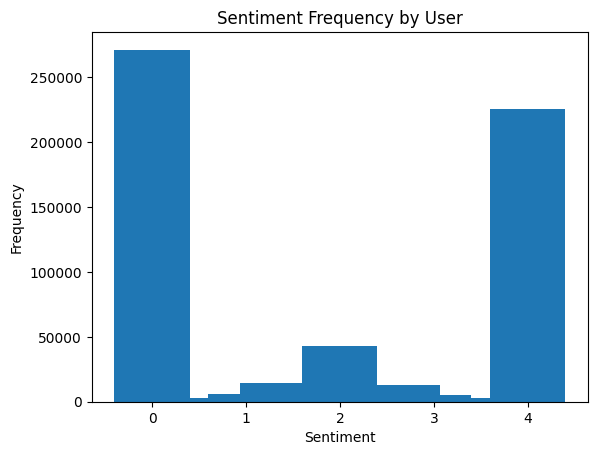

In [ ]:
sentiment_freq = Counter(sentiment_by_user)

labels = list(sentiment_freq.keys())
values = list(sentiment_freq.values())

fig, ax = plt.subplots()
ax.bar(labels, values)

ax.set_xlabel("Sentiment")
ax.set_ylabel("Frequency")
ax.set_title("Sentiment Frequency by User")

plt.show()

In [ ]:
filtered_users = df_sentiment_table[(df_sentiment_table['sentiment'] < 1.5) & (df_sentiment_table['count'] > 50)]
filtered_users = filtered_users.sort_values(by='count', ascending=False)

print(filtered_users)

                   user  sentiment  count
443734         lost_dog   0.000000    549
589359         tweetpet   0.000000    310
183237  SallytheShizzle   1.367521    281
460627      mcraddictal   0.913793    276
604012           wowlew   0.037736    212
...                 ...        ...    ...
559263      staceemcfly   1.391304     51
350829        gemmmmy_x   1.333333     51
108864          Kazcita   0.923077     51
58862     DukeSkywalker   1.446809     51
498698       omgitsafox   1.200000     51

[162 rows x 3 columns]


Encontramos usuario que suelen twitear mucho y son calificados negativamente

## Sentiment by "top influencers"

Busque los usuarios que mas fueron mentionados con @, y en estos si los tweets fueron positivos o negativos

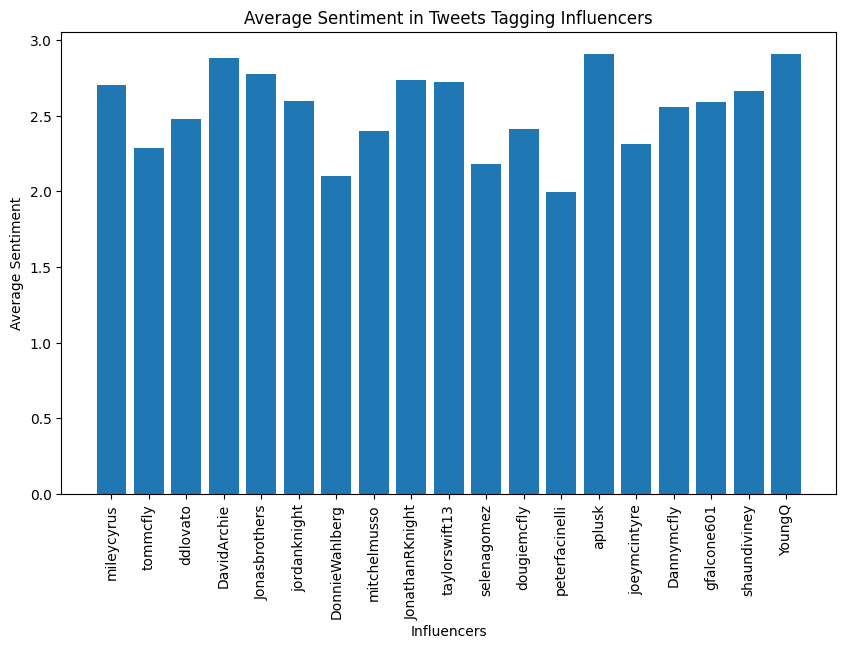

In [ ]:
influencers = ['mileycyrus', 'tommcfly', 'ddlovato', 'DavidArchie', 'Jonasbrothers',
               'jordanknight', 'DonnieWahlberg', 'mitchelmusso', 'JonathanRKnight',
               'taylorswift13', 'selenagomez', 'dougiemcfly', 'peterfacinelli',
               'aplusk', 'joeymcintyre', 'Dannymcfly','gfalcone601','shaundiviney','YoungQ']

sentiment_by_influencer = {}

for influencer in influencers:
  # Filter tweets that tagged the influencer
  tagged_tweets = df_relationships[df_relationships['users_tagged'].str.contains(influencer, na=False)]

  # Calculate the average sentiment
  average_sentiment = tagged_tweets['sentiment'].mean()

  # Store the result
  sentiment_by_influencer[influencer] = average_sentiment

# Create a bar chart to visualize the results
influencers_names = [influencer.replace('@', '') for influencer in influencers]
plt.figure(figsize=(10, 6))
plt.bar(influencers_names, list(sentiment_by_influencer.values()))
plt.xlabel('Influencers')
plt.ylabel('Average Sentiment')
plt.title('Average Sentiment in Tweets Tagging Influencers')
plt.xticks(rotation=90)
plt.show()


Los tweets donde se mencionan a influencers tienden a ser positivos.

## Word count

*mean_sentence_length es lo mismo que lenght (esta duplicado)

In [ ]:
data['Length'] = data['text'].str.len()

In [ ]:
def word_count(review):
    review_list = review.split()
    return len(review_list)

data['word_count'] = data['text'].apply(word_count)
data.head()

In [ ]:
data['mean_word_length'] = data['text'].map(lambda rev: np.mean([len(word) for word in rev.split()])).round(1)
data.head(10)

,tw_id,text,sentiment,Length,word_count,mean_word_length,mean_sent_length,sentiments
0,1988980167,yes please,4,11,2,4.5,11.0,positive
1,1880404304,much saying cant hypnotised keith barry anything,4,49,7,6.0,49.0,positive
2,1680771682,great thai chicken pizza loved seeing old co ...,0,90,15,5.0,90.0,negative
3,1979507798,bet london shows fab roll newcastle amp glasg...,0,91,15,5.1,91.0,negative
4,1974662314,hey music twitters im studio happy cause compl...,4,83,14,5.0,83.0,positive
5,2230267760,pure broke afraid tell better half sorry stil...,0,59,10,4.9,59.0,negative
6,1678007705,woke sitting last night pm guess two days with...,0,72,13,4.6,72.0,negative
7,1979032881,ox wat eva r u watching family guy frigin funy,4,47,10,3.7,47.0,positive
8,2190102011,remind everyone bestest,4,24,3,7.0,24.0,positive
9,2187905056,lvatt one minute album officially drops,4,39,6,5.7,39.0,positive


In [ ]:
def visualize(col):

    print()
    fig = plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    sns.boxplot(y=data[col], x=data['sentiments'])
    plt.ylabel(col, labelpad=12.5)

    plt.subplot(1,2,2)

    for sentiment in data['sentiments'].unique():
        sns.kdeplot(data[data['sentiments']==sentiment][col], label=sentiment)
    plt.legend()
    plt.xlabel('')
    plt.ylabel('')

    plt.show()


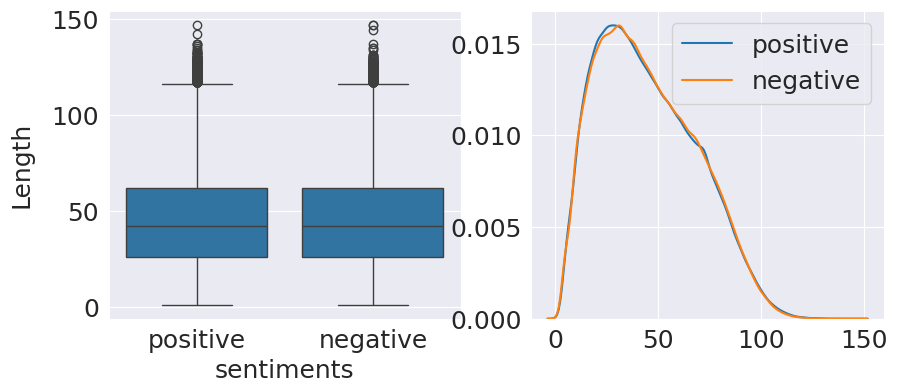

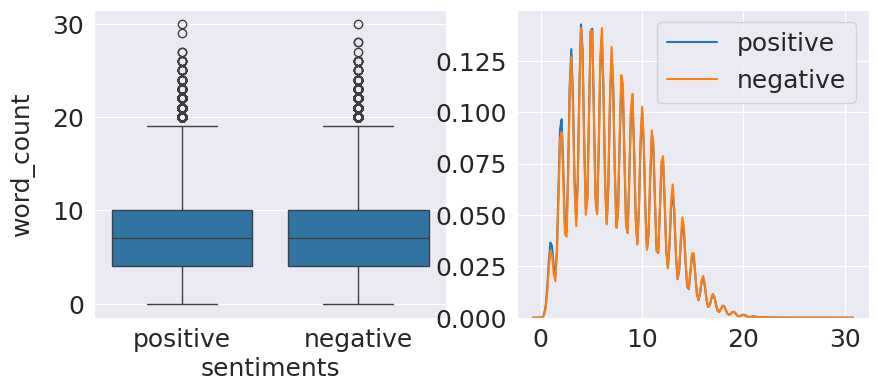

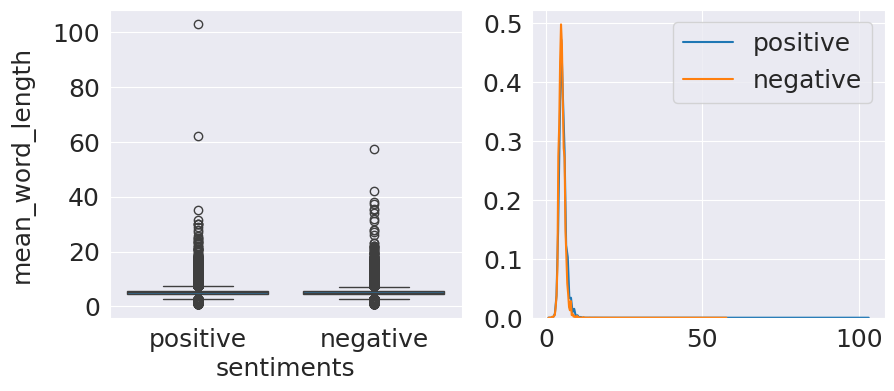

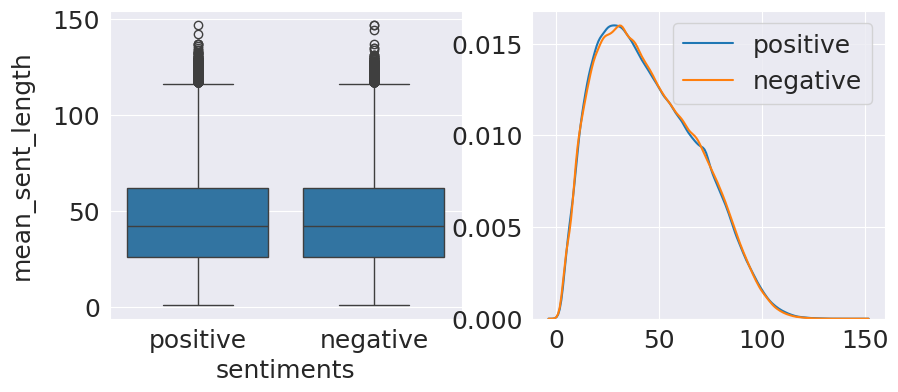

In [ ]:
features = data.columns.tolist()[3:-1]
for feature in features:
    visualize(feature)

No encontré diferencia en la longitud de tweets en función de su sentimiento.


## n-grams

In [ ]:
data = data.iloc[:, :3]
data.head()

,tw_id,text,sentiment
0,1988980167,yes please,4
1,1880404304,much saying cant hypnotised keith barry anything,4
2,1680771682,great thai chicken pizza loved seeing old co ...,0
3,1979507798,bet london shows fab roll newcastle amp glasg...,0
4,1974662314,hey music twitters im studio happy cause compl...,4


In [ ]:
def clean(review):

    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review)
    review = " ".join([word for word in review.split() if word not in stopwords.words('english')])

    return review

data['text'] = data['text'].apply(clean)
data.head()

In [ ]:
def corpus(text):
    text_list = text.split()
    return text_list
data['text_lists'] = data['text'].apply(corpus)
data.head()

,tw_id,text,sentiment,text_lists
0,1988980167,yes please,4,"[yes, please]"
1,1880404304,much saying cant hypnotised keith barry anything,4,"[much, saying, cant, hypnotised, keith, barry,..."
2,1680771682,great thai chicken pizza loved seeing old co ...,0,"[great, thai, chicken, pizza, loved, seeing, o..."
3,1979507798,bet london shows fab roll newcastle amp glasg...,0,"[bet, london, shows, fab, roll, newcastle, amp..."
4,1974662314,hey music twitters im studio happy cause compl...,4,"[hey, music, twitters, im, studio, happy, caus..."


In [ ]:
corpus = []
for i in trange(data.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += data['text_lists'][i]
len(corpus)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1439445/1439445 [00:07<00:00, 183109.43it/s]


10780717

In [ ]:
mostCommon = Counter(corpus).most_common(10)
mostCommon

[('day', 87679),
 ('good', 87404),
 ('get', 78797),
 ('like', 76910),
 ('go', 68085),
 ('today', 67913),
 ('going', 63942),
 ('quot', 63837),
 ('work', 63659),
 ('got', 60027)]

In [ ]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)

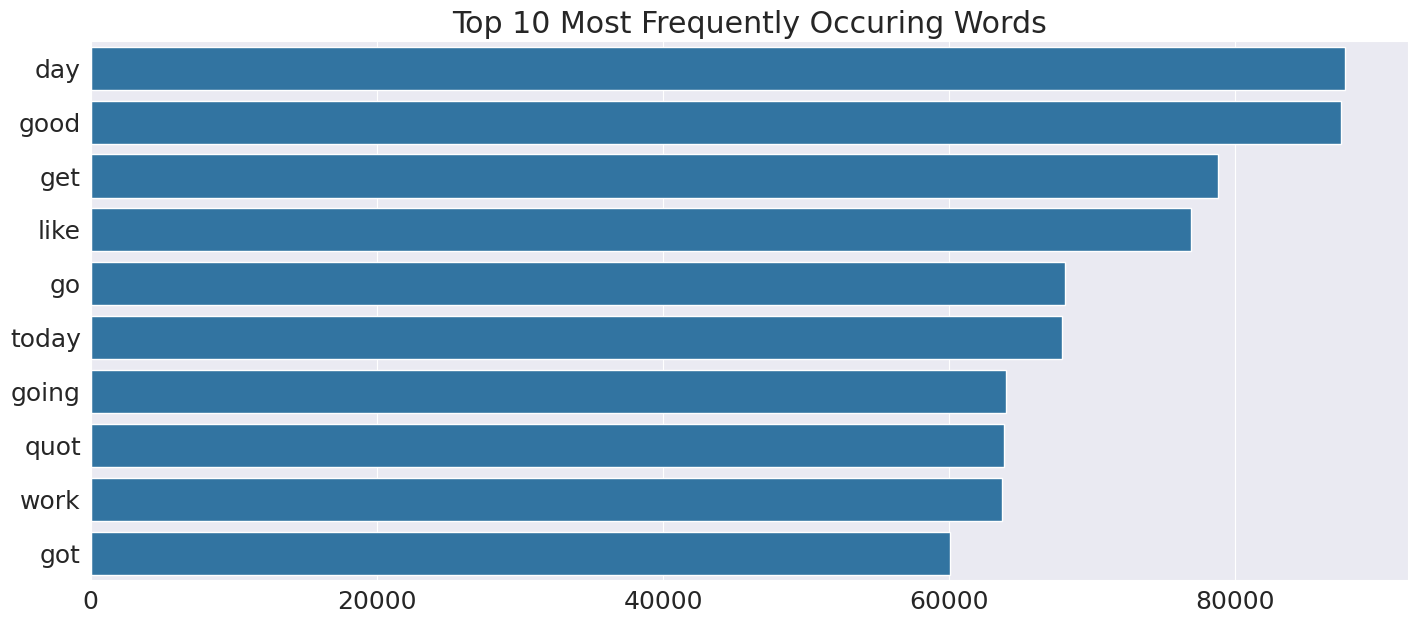

In [ ]:
sns.barplot(x=freq, y=words)
plt.title('Top 10 Most Frequently Occuring Words')
plt.show()

## Links web


In [ ]:
count_http = data['text'].apply(lambda x: len(re.findall(r'http', x))).sum()
print(f"Number of rows with 'http': {count_http}")


Number of rows with 'http': 38519


In [ ]:
def find_string_between_http_and_whitespace(text):
    pattern = r'http.*?(?=\s)'
    match = re.search(pattern, text)
    if match:
        return match.group(0)
    else:
        return None

df['http'] = df['text'].apply(find_string_between_http_and_whitespace)
df.head()

In [ ]:
df = df[['tw_id', 'http']]

df = df[df['http'].notnull()]
df.reset_index(drop=True, inplace=True)
df.head()

In [ ]:
df.shape

(33813, 2)

In [ ]:
df['urls'] = df['http'].apply(extract_main_website)
df.head()

,tw_id,http,urls
0,1467810369,http://twitpic.com/2y1zl,twitpic.com/
1,1467820863,http://tinyurl.com/dcuc33,tinyurl.com/
2,1467892720,http://twitpic.com/2y2wr,twitpic.com/
3,1467900244,http://twitpic.com/2y2yi,twitpic.com/
4,1467905653,https://www.mycomicshop.com/search?TID=395031,mycomicshop.com/


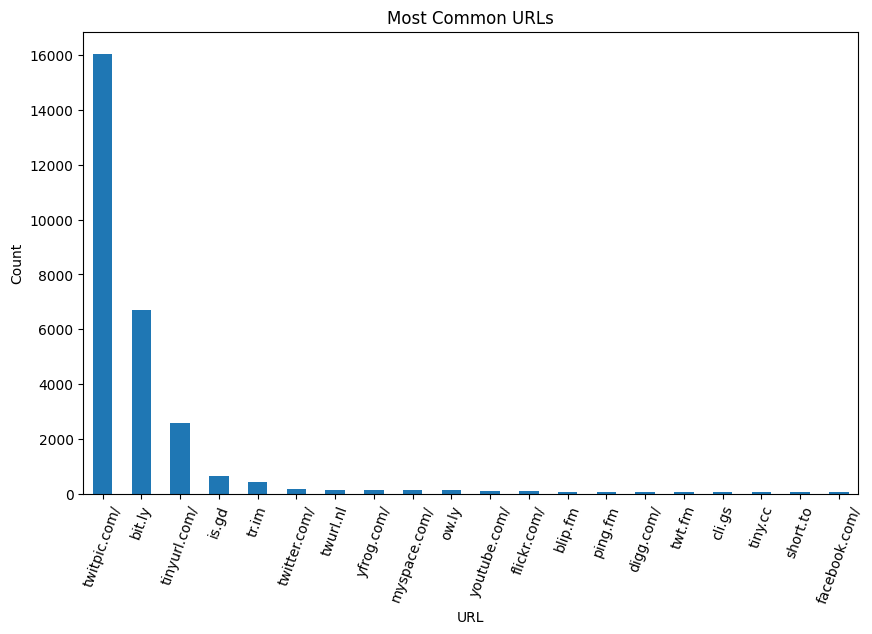

In [ ]:
most_common_urls = df['urls'].value_counts().head(20)
plot_most_common_urls = most_common_urls.plot(kind='bar', figsize=(10, 6))
plot_most_common_urls.set_xlabel('URL')
plot_most_common_urls.set_ylabel('Count')
plot_most_common_urls.set_title('Most Common URLs')
plot_most_common_urls.set_xticklabels(most_common_urls.index, rotation=70)
plt.show()

## LDA clustering

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(data['text'])

# Fit LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, vectorizer.get_feature_names_out(), 10)

Topic 0:
got new like http com waiting car home amp poor
Topic 1:
good way time yes morning lol like need make amp
Topic 2:
know lol twitter think want like oh dont im sorry
Topic 3:
quot love thanks http watching like bit great com new
Topic 4:
day going today work good tomorrow home night sleep im


No encontre nada interesante con este LDA. Tendria q probar con un numero distinto de clusters